### Milestone 3: Traditional statistical and machine learning methods, due Wednesday, April 19, 2017

Think about how you would address the genre prediction problem with traditional statistical or machine learning methods. This includes everything you learned about modeling in this course before the deep learning part. Implement your ideas and compare different classifiers. Report your results and discuss what challenges you faced and how you overcame them. What works and what does not? If there are parts that do not work as expected, make sure to discuss briefly what you think is the cause and how you would address this if you would have more time and resources. 

You do not necessarily need to use the movie posters for this step, but even without a background in computer vision, there are very simple features you can extract from the posters to help guide a traditional machine learning model. Think about the PCA lecture for example, or how to use clustering to extract color information. In addition to considering the movie posters it would be worthwhile to have a look at the metadata that IMDb provides. 

You could use Spark and the [ML library](https://spark.apache.org/docs/latest/ml-features.html#word2vec) to build your model features from the data. This may be especially beneficial if you use additional data, e.g., in text form.

You also need to think about how you are going to evaluate your classifier. Which metrics or scores will you report to show how good the performance is?

The notebook to submit this week should at least include:

- Detailed description and implementation of two different models
- Description of your performance metrics
- Careful performance evaluations for both models
- Visualizations of the metrics for performance evaluation
- Discussion of the differences between the models, their strengths, weaknesses, etc. 
- Discussion of the performances you achieved, and how you might be able to improve them in the future

#### Preliminary Peer Assessment

It is important to provide positive feedback to people who truly worked hard for the good of the team and to also make suggestions to those you perceived not to be working as effectively on team tasks. We ask you to provide an honest assessment of the contributions of the members of your team, including yourself. The feedback you provide should reflect your judgment of each team member’s:

- Preparation – were they prepared during team meetings?
- Contribution – did they contribute productively to the team discussion and work?
- Respect for others’ ideas – did they encourage others to contribute their ideas?
- Flexibility – were they flexible when disagreements occurred?

Your teammate’s assessment of your contributions and the accuracy of your self-assessment will be considered as part of your overall project score.

Preliminary Peer Assessment: [https://goo.gl/forms/WOYC7pwRCSU0yV3l1](https://goo.gl/forms/WOYC7pwRCSU0yV3l1)

## Below is code to implement our models. After its implementation, we describe the purpose and functionalities of the 2 models chosen applied to 1 dataset.

We implemented both a SGD and Random forest once on a dataset consisting of a traditional feature set holding predictors such as crew, director, actors, etc. We also implemented the same models after creating a vectorization of each movies overview description using most frequent words for classification. Below is the code to create and tune all 4 models.

In [1]:
import cPickle
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import make_scorer, hamming_loss, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import MultiLabelBinarizer
import matplotlib.pyplot as plt
import re
from scipy import sparse

In [2]:
def load_part(file_name):
    with open(file_name, 'rb') as handle:
        return cPickle.load(handle)

In [3]:
def cutoff_labels(labels, cutoff):
    mlb = MultiLabelBinarizer()
    label_df = pd.DataFrame(mlb.fit_transform(labels))
    label_df.columns = mlb.classes_
    label_number_df = pd.DataFrame({'cnt': label_df.sum(axis=0)})
    major_genres = set(label_number_df[label_number_df['cnt'] > cutoff].index)
    return major_genres


def get_major_genres(plot_dict):
    labels = np.array([d['genres'] for d in plot_dict.values() if 'genres' in d and 'plot' in d])
    # only leave genres mentioned in 2000 movies or more
    major_genres = cutoff_labels(labels, 2000)
    return major_genres

In [4]:
root_folder = '..'

In [5]:
# load TMDB movies dataset
tmdb_movies = load_part(root_folder + '/data/tmdb_info.pickle')

plot_dict = load_part(root_folder + '/data/plot.pickle')

cast_dict = load_part(root_folder + '/data/cast10K.pickle')

major_genres = get_major_genres(plot_dict)

sample_tmdb_ids = np.array([tmdb_id for tmdb_id, d in cast_dict.items() if
                            'genres' in d and 'genres' in plot_dict[tmdb_id] and tmdb_id in plot_dict and 'plot' in
                            plot_dict[tmdb_id]])
print len(sample_tmdb_ids)

7669


In [6]:
def prepare_text_data(tmdb_dict, plot_dict, major_genres, sample_tmdb_ids):
    # add 'overview' from TMDB to 'plot' from IMDB (it is a list)
    for tmdb_id, imdb_movie in plot_dict.iteritems():
        if ('plot' in imdb_movie and tmdb_id in tmdb_dict and 'overview' in tmdb_dict[tmdb_id].__dict__ and
                    tmdb_dict[tmdb_id].__dict__['overview'] is not None):
            imdb_movie['plot'].append(tmdb_dict[tmdb_id].__dict__['overview'])

    labels = np.array(
        [major_genres.intersection(plot_dict[tmdb_id]['genres']) for tmdb_id in sample_tmdb_ids if
         'genres' in plot_dict[tmdb_id] and 'plot' in plot_dict[tmdb_id]])
    print len(labels)

    # create the labels vector with only major genres
    mlb = MultiLabelBinarizer()
    y = mlb.fit_transform(labels)
    # the plot consists of a few parts, join them together
    features = np.array([''.join(plot_dict[tmdb_id]['plot']) for tmdb_id in sample_tmdb_ids if
                         'genres' in plot_dict[tmdb_id] and 'plot' in plot_dict[tmdb_id]])

    vectorizer = TfidfVectorizer(
        stop_words=stopwords.words("english"),
        token_pattern='[a-zA-Z]+[0-9]*',
        max_df=0.9,
        min_df=0.0001,
        dtype=np.float32,
    )
    return features, y, mlb.classes_, vectorizer


In [7]:
def prepare_cast_data(tmdb_dict, cast_dict, major_genres, sample_tmdb_ids):
    columns = [
        'director',
        'cast',
        'casting director',
        'miscellaneous crew',
        'original music',
        'producer',
        'cinematographer',
        'costume designer',
        'art direction']

    labels = np.array(
        [major_genres.intersection(cast_dict[tmdb_id]['genres']) for tmdb_id in sample_tmdb_ids if
         'genres' in cast_dict[tmdb_id]])
    # create the labels vector with only major genres
    mlb = MultiLabelBinarizer()
    y = mlb.fit_transform(labels)

    # combine all names separated by '|'
    features = []
    for tmdb_id in sample_tmdb_ids:
        imdb_movie = cast_dict[tmdb_id]
        if 'genres' not in imdb_movie:
            continue
        l = []
        for c in columns:
            if (c in imdb_movie):
                l = l + [c['name'].encode('utf-8') for c in imdb_movie[c]]
        # add crew and cast from TMDB
        if (tmdb_id in tmdb_dict):
            tmdb_movie = tmdb_dict[tmdb_id].__dict__
            if ('crew' in tmdb_movie):
                l = l + [c['name'].encode('utf-8') for c in tmdb_movie['crew']]
            if ('cast' in tmdb_movie):
                l = l + [c['name'].encode('utf-8') for c in tmdb_movie['cast']]
        # remove duplicates before joiniing
        features.append('|'.join(set(l)))

    vectorizer = CountVectorizer(
        max_df=0.99,
        min_df=0.0002,
        stop_words=stopwords.words("english"),
        tokenizer=lambda x: x.split('|'),
        dtype=np.float32)

    return features, y, mlb.classes_, vectorizer


In [8]:
# get labels / features from the cast / crew data
cast_features, cast_y, cast_mlb_classes, cast_vectorizer = prepare_cast_data(tmdb_movies, cast_dict, major_genres,
                                                                             sample_tmdb_ids)

print np.shape(cast_features)
print np.shape(cast_y)
print len(cast_mlb_classes)

mlb_classes = cast_mlb_classes

# get labels / features from the text data
text_features, text_y, text_mlb_classes, text_vectorizer = prepare_text_data(tmdb_movies, plot_dict, major_genres,
                                                                             sample_tmdb_ids)

print np.shape(text_features)
print np.shape(text_y)
print len(text_mlb_classes)

(7669L,)
(7669L, 15L)
15
7669
(7669L,)
(7669L, 15L)
15


In [9]:
def get_values(uni, genres):
    ret_dic = {}
    for dex, gen in enumerate(genres):
        loc = uni.find(gen)
        if dex < len(genres)-1:
            next_loc = uni.find(genres[dex+1])
            nums = re.findall(r'\d+', uni[loc+len(gen):next_loc])
            ap_dic = {'precision':float(nums[1])*.01, 'recall':float(nums[3])*.01, 'f1-score':float(nums[5])*.01, 'support':float(nums[6])}
            ret_dic[gen] = ap_dic 
    return ret_dic
def to_df(dic):
    ret_df = pd.DataFrame(columns = ['title','precision', 'recall', 'f1-score', 'support'])
    for k, v in dic.items():
        ret_df = ret_df.append({'title':k, 'precision':v['precision'], 'recall':v['recall'], 'f1-score':v['f1-score'], 'support':v['support']}, ignore_index=True)
    return ret_df

In [10]:
# split into test / train data
cast_F_train, cast_F_test, text_F_train, text_F_test, y_train, y_test = train_test_split(cast_features,
                                                                                         text_features, cast_y,
                                                                                         test_size=0.25,
                                                                                         random_state=42)

cast_X_train = cast_vectorizer.fit_transform(cast_F_train)
cast_X_test = cast_vectorizer.transform(cast_F_test)

print np.shape(cast_X_train)
print np.shape(cast_X_test)

text_X_train = text_vectorizer.fit_transform(text_F_train)
text_X_test = text_vectorizer.transform(text_F_test)

print np.shape(text_X_train)
print np.shape(text_X_test)

X_train = sparse.hstack((cast_X_train, text_X_train))
X_test = sparse.hstack((cast_X_test, text_X_test))

print np.shape(X_train)
print np.shape(X_test)


(5751, 31278)
(1918, 31278)
(5751, 35210)
(1918, 35210)
(5751, 66488)
(1918, 66488)


In [11]:
def sgd(X_train, X_test, y_train, y_test, mlb_classes):
    param_grid = {
        'estimator__alpha': np.logspace(-5, -1, num=50),
    }
    model = OneVsRestClassifier(SGDClassifier(class_weight='balanced', random_state=761))
    model_tuning = GridSearchCV(
        model,
        param_grid=param_grid,
        scoring=make_scorer(hamming_loss, greater_is_better=False),
        cv=3,
        n_jobs=2,
        verbose=1,
    )
    model_tuning.fit(X_train, y_train)
    y_test_pred = model_tuning.predict(X_test)

    print model_tuning.best_params_
    print 'hamming loss: %.3f' % hamming_loss(y_test, y_test_pred)
    print classification_report(y_train, model_tuning.predict(X_train), target_names=mlb_classes, digits=3)
    print classification_report(y_test, y_test_pred, target_names=mlb_classes, digits=3)
    
    return(classification_report(y_train, model_tuning.predict(X_train), target_names=mlb_classes), classification_report(y_test, model_tuning.predict(X_test), target_names=mlb_classes))
    
#sgd_model_analysis = sgd(X_test, X_train, y_test, y_train, mlb_classes)

In [12]:
train, test = sgd(X_test, X_train, y_test, y_train, mlb_classes)
#this makes our sgd classification report for the crew/actor/director and overview data
crew_test_sgd_model_analysis_df = to_df(get_values(test, mlb_classes))
crew_train_sgd_model_analysis_df = to_df(get_values(train, mlb_classes))

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   28.1s
[Parallel(n_jobs=2)]: Done 150 out of 150 | elapsed:   36.2s finished


{'estimator__alpha': 0.0071968567300115137}
hamming loss: 0.115
             precision    recall  f1-score   support

     Action      0.984     0.925     0.954       200
  Adventure      1.000     0.893     0.944       159
  Animation      0.976     0.836     0.900       146
     Comedy      0.985     0.880     0.930       525
      Crime      0.988     0.890     0.936       181
Documentary      0.949     0.982     0.965       227
      Drama      0.969     0.978     0.974       837
     Family      0.943     0.886     0.913       149
    Fantasy      0.972     0.990     0.981       105
     Horror      0.960     0.933     0.946       178
    Mystery      0.948     0.978     0.963        93
    Romance      1.000     0.861     0.925       295
     Sci-Fi      0.979     1.000     0.989        94
      Short      0.975     0.790     0.873       200
   Thriller      0.976     0.932     0.953       264

avg / total      0.975     0.920     0.945      3653

             precision    recall

In [13]:
def random_forest(X_test, X_train, y_test, y_train, mlb_classes):
    param_grid = {
        'min_samples_leaf': (1, 2, 50),
        'max_features': ('auto', 'sqrt', 'log2', 0.2),
    }
    model = RandomForestClassifier(n_estimators=50, random_state=761,class_weight='balanced')
    model_tuning = GridSearchCV(
        model,
        param_grid=param_grid,
        scoring=make_scorer(hamming_loss, greater_is_better=False),
        cv=3,
        n_jobs=-1,
        verbose=3,
    )
    model_tuning.fit(X_train, y_train)
    #print model_tuning.best_params_
    #print classification_report(y_train, model_tuning.predict(X_train), target_names=mlb_classes)
    #print classification_report(y_test, model_tuning.predict(X_test), target_names=mlb_classes)
    return(classification_report(y_train, model_tuning.predict(X_train), target_names=mlb_classes), classification_report(y_test, model_tuning.predict(X_test), target_names=mlb_classes))
    
#forest_model_analysis = random_forest(X_test, X_train, y_test, y_train, mlb_classes)

In [14]:
train, test = random_forest(X_test, X_train, y_test, y_train, mlb_classes)
#this makes our forest classification report for the crew/actor/director and overview data
crew_test_forest_model_analysis_df = to_df(get_values(test, mlb_classes))
crew_train_forest_model_analysis_df = to_df(get_values(train, mlb_classes))

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   47.4s
[Parallel(n_jobs=-1)]: Done  34 out of  36 | elapsed:  6.4min remaining:   22.6s
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:  6.4min finished
C:\Users\Keenan\Anaconda2\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# Detailed description and implementation of two different models

The evolution of our dataset:
We initially wanted to run 2 models across two types of datasets. However, we saw it as unnecessarily confusing, computationally expensive and simpler if we combined the data. In its original form, one dataset consisted of a movies crew/director/actors and other production specific features. The other dataset was simply the overview (a description of the movie), within TMDB. These are different types of data so we had to ensure they were properly represented as features. Through vectorization, we were able to transform the overview into a feature set. From there, we combined it with a feature set consisting of production specific feature groups detailed above. With our new dataset, we fit the chosen models and found different measures of accuracy. We were aware that given out multilabel classes, some models would work and some would need prior adjustment. We also considered the drastic class imbalance that occurs as some genres are much more common than others. Our models accounted for this, but we selected our performance metrics accordingly.

After analyzing many classification models and comparing baseline results, we have decided to use a stochastic gradient dissent linear support vector machine model and a random forest for this milestone. We chose and tuned these models for several reasons based on their performance, similarities and differences.

The stochastic gradient dissent linear support vector machine model aka SGD model:
After testing out different support vector machine kernels and logistic regressions, we found that using an SGD learning mechanism on a linear support vector machine was computationally efficient and yielded good results. This model cannot natively handle multilabel classes so we were forced to use one vs rest classification (this fits a new model for each class). Through cross validation, we tuned the parameters according to a Hamming Loss. We were aware that this kind of model comparison can favor models that over classify the dominant class (especially with the amount of class imbalance in the dataset). So we made sure it weighted classes differently based on the observations falling under that class.

The Random Forest model:
We wanted to utilize a model that could natively support multilabel classes (unlike our SGD) and creatively handle some of the more specific features in our dataset. We chose a random forest because of its performance. Through cross validation we tuned the minimum sample leaf and max features. We also accounted for class imbalance using the built in method in Sklearn. We found that our random forest underperformed compared to the SGD model, but still yielded important information on our dataset.


# Description of your performance metrics

As we described in our last milestone, we will be using a multilabel classification approach. Some movies have one genres while most have multiple genres.  This naturally creates a problem in classification as some observations fall under multiple classes. Further, making a class for every possible combination of genres is infeasible as it result in drastic class imbalances and under representation (the highly specific combinations will only have one or two corresponding movies). However, multilabel classification also has limitations, particularly when implementing and observing performance metrics. As we described previously, to run an SGD (or logistic regression, and other classifier models), we had to use an onevsrest classifier. A random forest can handle multilabel classification natively and we wanted to express the pros and cons of each model.

There are also performance considerations. One vs the rest method fits as many models as there are labels in the dataset.  First we tried to use traditional linear support vector classifier but having over 20 labels even on 3K dataset the grid search usually takes hours on our hardware. That is why we decided to use SGD based classifier with the appropriate loss function ('hinge' for SVC or 'log' for logistic regression). This proved to be better solution easily scaling to handle 10K dataset with lots of features. We also wanted to evaluate a random forest classifier because it can handle multilabel classification natively. We also discovered that random forest scales quite good and can easily handle our 10K dataset.

To analyze the models, we decided to use 3 accuracy/error based measures. Using the classification_report function in sklearn, we returned precision, recall and the f-1 score of our models across genres. In this context, precision is the fraction of correct results divided by the number of all returned results while recall is the number of correct results divided by the number of results that should have been returned. Finally, the f1-score is a measure of the model's accuracy, it considers both precision and recall to compute a score. We decided to use the f-1 score to compare the accuracy across models; we did this for several reasons, mainly because of massive class imbalance, we describe below. We considered using a roc or auc curve, but it is traditionally used in binary classification. It can adapt to the multilabel classification methodology, but it would be necessary to binarize the output of the model. Lastly, we applied the same performance metrics to the two used datasets (crew/actor/director dataset vs overview dataset). Cross comparing accuracy across datasets isn't as helpful as comparing accuracy within a dataset across models. The f1-score allows us to analyze the performance of our models which both use very different algorithms. Our visualizations reflect the differences in performance between models across both datasets.

# Careful performance evaluations for both models

#### Baseline classifier (dummy classifier) and metrics

To further check our models, we implemented three dummy classifiers.  The stratified classifier is a classification algorithm that takes the training set class distribution and assigns classes to the test set based on that distribution. The uniform dummy classifier assigns classes in uniform to all observations in the testing set. Finally, the most frequent dummy classifier assigns the most frequent class to every observation. However, in this context, our classes are multilabels. We compared accuracy across genres of both our SGD and Random Forest model against each other and the dummy classifiers. Choosing the right metric is a challenge within itself as some may be misleading while others are not relevant.

In [15]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report, accuracy_score, hamming_loss, zero_one_loss, jaccard_similarity_score


def evaluate_baseline(X_train, X_test, y_train, y_test, mlb_classes, strategy):
    print strategy

    num_y_columns = y_train.shape[1]

    y_test_pred_list = []
    for i in xrange(num_y_columns):
        one_y_train = y_train[:, i]
        model = DummyClassifier(strategy=strategy)
        model.fit(X_train, one_y_train)
        one_y_test_pred = model.predict(X_test)
        y_test_pred_list.append(one_y_test_pred)

    y_test_pred = np.array(y_test_pred_list).T

    print 'accuracy score: %.3f' % accuracy_score(y_test, y_test_pred)
    print 'jaccard similarity score: %.3f' % jaccard_similarity_score(y_test, y_test_pred)
    print 'hamming loss: %.3f' % hamming_loss(y_test, y_test_pred)
    print 'zero one loss: %.3f' % zero_one_loss(y_test, y_test_pred)
    print classification_report(y_test, y_test_pred, target_names=mlb_classes)


evaluate_baseline(X_train, X_test, y_train, y_test, cast_mlb_classes, 'stratified')
evaluate_baseline(X_train, X_test, y_train, y_test, cast_mlb_classes, 'uniform')
evaluate_baseline(X_train, X_test, y_train, y_test, cast_mlb_classes, 'most_frequent')

stratified
accuracy score: 0.031
jaccard similarity score: 0.136
hamming loss: 0.202
zero one loss: 0.969
             precision    recall  f1-score   support

     Action       0.09      0.12      0.10       200
  Adventure       0.05      0.04      0.05       159
  Animation       0.10      0.08      0.09       146
     Comedy       0.26      0.27      0.27       525
      Crime       0.14      0.15      0.15       181
Documentary       0.10      0.09      0.09       227
      Drama       0.45      0.46      0.45       837
     Family       0.13      0.11      0.12       149
    Fantasy       0.05      0.05      0.05       105
     Horror       0.08      0.10      0.09       178
    Mystery       0.06      0.08      0.07        93
    Romance       0.13      0.12      0.13       295
     Sci-Fi       0.05      0.05      0.05        94
      Short       0.10      0.10      0.10       200
   Thriller       0.16      0.16      0.16       264

avg / total       0.21      0.21      0.21  

Hamming Loss is often used for classification accuracy, but as we stated before, the dataset has massive class imbalance. This can result in the model over assigning observations to the majority class, simply because it will be more accurate on the whole dataset if it does so. However, a model like this has very poor applicability as it doesn't give us real information as to which observations belong to which class. The SGD and Random Forest can take arguments in Sklearn noting that there may class imbalance. We also tuned our model with relevant parameters to avoid class imbalance. As one can see in our most frequent dummy classifier (which has the highest Hamming Loss) simple measures of accuracy can be deceitful as to the overall efficacy of a model.

In [16]:
print 'Forest model run on crew/director/actor dataset'
print crew_test_forest_model_analysis_df
print 'SGD model run on crew/director/actor dataset'
print crew_test_sgd_model_analysis_df

Forest model run on crew/director/actor dataset
          title  precision  recall  f1-score  support
0       Mystery       0.00    0.00      0.00     93.0
1       Romance       0.55    0.04      0.07    295.0
2         Short       0.92    0.12      0.20    200.0
3        Sci-Fi       0.00    0.00      0.00     94.0
4        Family       0.86    0.13      0.22    149.0
5        Horror       0.00    0.00      0.00    178.0
6         Crime       0.67    0.02      0.04    181.0
7         Drama       0.58    0.62      0.60    837.0
8       Fantasy       0.00    0.00      0.00    105.0
9     Animation       0.88    0.15      0.26    146.0
10    Adventure       0.00    0.00      0.00    159.0
11       Action       0.00    0.00      0.00    200.0
12       Comedy       0.86    0.10      0.17    525.0
13  Documentary       0.91    0.31      0.47    227.0
SGD model run on crew/director/actor dataset
          title  precision  recall  f1-score  support
0       Mystery       0.20    0.03      0.0

As one can see from the f1 scores for each sub category, our SGD model generally outperformed our random forest model. It is worth noting that some of the f1-scores of the random forest dataset are 0 (precision and recall are as well for those genres). This is because some of the under-represented classes are being phased out of the classification model given their lack of impact in creating the random forest. In a sense, they model is ignorant to them while it still classifies drama (the most used genre) incredibly well (better than the SGD). This is a natural weakness of class imbalance that we try to account for, while preventing our model from overfitting the training set in its entire detail.

# Visualizations of the metrics for performance evaluation

### Models based on crew/director/feature set data

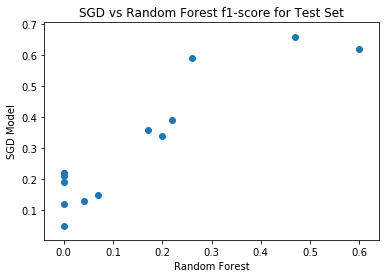

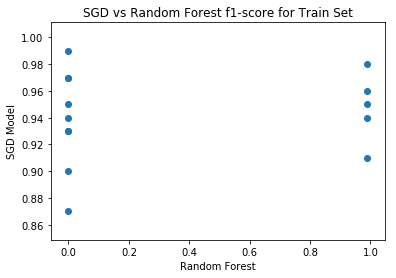

In [17]:
plt.scatter(crew_test_forest_model_analysis_df['f1-score'], crew_test_sgd_model_analysis_df['f1-score'])
plt.ylabel('SGD Model')
plt.xlabel('Random Forest')
plt.title('SGD vs Random Forest f1-score for Test Set')
plt.show()
plt.scatter(crew_train_forest_model_analysis_df['f1-score'], crew_train_sgd_model_analysis_df['f1-score'])
plt.ylabel('SGD Model')
plt.xlabel('Random Forest')
plt.title('SGD vs Random Forest f1-score for Train Set')
plt.show()

We decided to use the f1-score as our main source of comparing models. It shows us a more complete representation of a models accuracy and relevance than just precision or recall. In the above visualizations, each point in the graph is a genre. The axis consists of each model. In the first graph, the testing graph, we can clearly see that some genres are just harder to classify than others, there is a sizeable cluster of lower performing genres (in terms of f1-score). But from there, using the axis scale, we can also see that the SGD model generally classifies more genres better than a Random Forest model (with our current parameters). In the training set visual, we can see the SGD classifies all genres extremely well while the forest ignores some of them resulting in an f1-score of 0.

# Discussion of the differences between the models, their strengths, weaknesses, etc.

Given the inherent difficulties of multilabel classification and dealing with an imbalanced dataset, the models we select will also have some limitations. One of the biggest limitations of our SGD model is its inability to natively classify multilabel classes. As we described earlier, we had to use a one vs rest classification that fits as many models as we have labels. The SGD model is defined as "Linear classifiers (SVM, logistic regression, a.o.) with SGD training." in Sklearn. This means weaknesses in an SVM may show in an SGD model. Finally, because of the size of our dataset and its complexity, we opted to only use a linear kernel when originally toying with an SVM. It greatly improves runtime and requires less tuning parameters but may sacrifice predictive ability. Our observations on our linear SVM drove us to implement the SGD.

The SGD model does have pros to its cons. It seems to be fairly accurate and does a good job, when accounting for imbalanced class data, at finding movies in each genre. Its computation time is extremely quick and with the proper tuning it can become a reliable model. Further, it is based on a methodology that can be applied to logistic regression or support vector machines. It inherits the robustness of these model algorithms (in this case the Linear SVM).

The Random Forest model clearly has limitations in accuracy and computation time. While it is fast to train, making a highly accurate forest model requires more trees which will greatly slow down computation. Given the intricate dataset we have, a highly trained forest may be extremely accurate but infeasible if computation time is too long. Our dataset has many labels some underrepresented and finding those little groves that define a multilabel that has one or two observations will be extremely difficult. Further, if we were to create a highly specific model, it will be rigid and unmalleable when trying to adapt to different datasets about movies even with the same features (over-fitted). We cross validated when choosing parameters to account for this but it may lead to some inaccuracy on the final testing dataset (because a lack of specificity).

The random forest also has some pros. First off, it natively supports multilabel classes. This is huge as it takes out the need to use one vs rest classifier. Secondly, I believe that if we had a sub sampled dataset with relatively no class imbalance, it would perform very well. Here it could account for the specific groves and curves through a high number of trees while still ensuring that the less represented classes can be classified. 

# Discussion of the performances you achieved, and how you might be able to improve them in the future

As described at the beginning of our document, our models are the creation of analysis on other similar models used on a dataset that has been cut and combined. While we believe we have taken the best steps to finding a good classification model, able to predict genre, there are other avenues we want to explore. First, when combining datasets based on features, we believe our feature set may have extensively increased. This could benefit from some form of dimensionality reduction like PCA. However, we will have to consider this effect on textual data from movie overviews.

We have also experimented with color palette see if the posters color palette convey any genre information. It might make some sense considering the poster artists likely to use some similar color tricks to channel genre information to the potential audience. This process is computationally expensive and creating a feature set out of the color palette will take a while. We hope to analyze this as a possible 3rd major feature predictive set.

Lastly, although we tuned based on appropriate loss parameters, we hope to tune our models further. We especially want to investigate the pros and cons of manipulating our forest's trees more. We are aware of the computational limitations but would look for a work around. Given the impressive performance of our SGD model, we may want to apply the same stochastic learning process to a logistic regression or alternate support vector machine with a degree or radial kernel (if computation allows). We have also begun experimenting with different metrics to compare models when cross validating. There may be a better metric than Hamming Loss when finding the best models given a set of parameters. This will, hopefully, help us in finding the most accurate and most applicable model.